# MELD Emotion Recognition Using Multimodal Deep Learning

This notebook implements emotion recognition on the MELD dataset using three approaches:
1. **LSTM Model** - Text-based emotion classification using pre-computed embeddings
2. **CNN Model** - Audio-based emotion classification using 2D spectrograms
3. **Fusion Model** - Combined multimodal approach leveraging both text and audio

**Dataset:** MELD (Multimodal EmotionLines Dataset)
- Text embeddings: `MELD.Raw/text_emotion.pkl`
- Audio spectrograms: `MELD_spectrograms/*.npy` (generated via `audio_to_spectrogram.ipynb`)
- Labels: `MELD.Raw/train_sent_emo.csv`, `dev_sent_emo.csv`, `test_sent_emo.csv`

## 1. Setup and Configuration

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Conv2D,
                                      MaxPooling2D, Flatten, Input, 
                                      Concatenate, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("✓ Libraries imported successfully!")

TensorFlow version: 2.20.0
NumPy version: 2.3.5
Pandas version: 2.3.3
✓ Libraries imported successfully!


## 2. Load and Prepare Data

In [13]:
# Load text embeddings and labels from MELD dataset
print("Loading MELD data...")
print("=" * 70)

# Load text embeddings (pre-computed contextual features)
pkl_path = 'MELD.Raw/text_emotion.pkl'
if not os.path.exists(pkl_path):
    raise FileNotFoundError(f"Text embeddings not found at: {pkl_path}")

with open(pkl_path, 'rb') as f:
    text_data = pickle.load(f)

train_text_dict, val_text_dict, test_text_dict = text_data
print(f"✓ Text embeddings loaded: {len(train_text_dict)} train, {len(val_text_dict)} val, {len(test_text_dict)} test dialogues")

# Load labels from CSV files
base_path = 'MELD.Raw'
train_labels_df = pd.read_csv(os.path.join(base_path, 'train_sent_emo.csv'))
dev_labels_df = pd.read_csv(os.path.join(base_path, 'dev_sent_emo.csv'))
test_labels_df = pd.read_csv(os.path.join(base_path, 'test_sent_emo.csv'))

print(f"✓ Labels loaded: {len(train_labels_df)} train, {len(dev_labels_df)} val, {len(test_labels_df)} test utterances")

# Create label lookup dictionaries
def create_label_dict(df):
    """Create dictionary mapping (dialogue_id, utterance_id) -> emotion"""
    return {(row['Dialogue_ID'], row['Utterance_ID']): row['Emotion'] 
            for _, row in df.iterrows()}

train_label_dict = create_label_dict(train_labels_df)
val_label_dict = create_label_dict(dev_labels_df)
test_label_dict = create_label_dict(test_labels_df)

# Extract utterances with labels
def extract_utterances_with_labels(text_dict, label_dict):
    """Extract text features and labels for valid utterances"""
    X_text_list, y_list, dia_ids, utt_ids = [], [], [], []
    
    for dia_id in text_dict.keys():
        text_features = text_dict[dia_id]
        for utt_idx in range(text_features.shape[0]):
            if np.any(text_features[utt_idx]):  # Non-zero utterance
                key = (int(dia_id), utt_idx)
                if key in label_dict:
                    X_text_list.append(text_features[utt_idx])
                    y_list.append(label_dict[key])
                    dia_ids.append(dia_id)
                    utt_ids.append(utt_idx)
    
    return np.array(X_text_list), y_list, dia_ids, utt_ids

print("\nExtracting text utterances with labels...")
X_text_train, train_emotions, train_dia_ids, train_utt_ids = extract_utterances_with_labels(train_text_dict, train_label_dict)
X_text_val, val_emotions, val_dia_ids, val_utt_ids = extract_utterances_with_labels(val_text_dict, val_label_dict)
X_text_test, test_emotions, test_dia_ids, test_utt_ids = extract_utterances_with_labels(test_text_dict, test_label_dict)

print(f"  Train: {len(X_text_train)} utterances")
print(f"  Val: {len(X_text_val)} utterances")
print(f"  Test: {len(X_text_test)} utterances")

# Encode labels
le = LabelEncoder()
all_emotions = train_emotions + val_emotions + test_emotions
le.fit(all_emotions)

y_train = le.transform(train_emotions)
y_val = le.transform(val_emotions)
y_test = le.transform(test_emotions)

num_classes = len(le.classes_)
print(f"\n✓ Labels encoded: {num_classes} emotion classes")
print(f"  Classes: {list(le.classes_)}")

# Convert to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Reshape text data for LSTM (samples, timesteps, features)
X_text_train = X_text_train.reshape(X_text_train.shape[0], 1, X_text_train.shape[1])
X_text_val = X_text_val.reshape(X_text_val.shape[0], 1, X_text_val.shape[1])
X_text_test = X_text_test.reshape(X_text_test.shape[0], 1, X_text_test.shape[1])

print(f"\n✓ Text data prepared for LSTM: {X_text_train.shape}")
print("=" * 70)

Loading MELD data...
✓ Text embeddings loaded: 1038 train, 114 val, 280 test dialogues
✓ Labels loaded: 9989 train, 1109 val, 2610 test utterances

Extracting text utterances with labels...
  Train: 9989 utterances
  Val: 1109 utterances
  Test: 2610 utterances

✓ Labels encoded: 7 emotion classes
  Classes: [np.str_('anger'), np.str_('disgust'), np.str_('fear'), np.str_('joy'), np.str_('neutral'), np.str_('sadness'), np.str_('surprise')]

✓ Text data prepared for LSTM: (9989, 1, 600)

Extracting text utterances with labels...
  Train: 9989 utterances
  Val: 1109 utterances
  Test: 2610 utterances

✓ Labels encoded: 7 emotion classes
  Classes: [np.str_('anger'), np.str_('disgust'), np.str_('fear'), np.str_('joy'), np.str_('neutral'), np.str_('sadness'), np.str_('surprise')]

✓ Text data prepared for LSTM: (9989, 1, 600)


## 3. LSTM Model (Text-Based Classification)

### 3.1 Build LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_lstm_model(input_shape, num_classes):
    """
    Build LSTM model with INCREASED REGULARIZATION to prevent overfitting.
    """
    model = Sequential(name='LSTM_Text_Model')
    
    # LSTM Layer 1: Added L2 Regularization & Increased Dropout to 0.5
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape, 
                   kernel_regularizer=l2(0.001))) 
    model.add(Dropout(0.5)) # Increased from 0.3
    model.add(BatchNormalization())
    
    # LSTM Layer 2: Added L2 Regularization & Increased Dropout
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) # Increased from 0.3
    model.add(BatchNormalization())
    
    # Dense Layer 1: Added L2 & Increased Dropout
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) # Increased from 0.3
    
    # Dense Layer 2: Added L2 & Increased Dropout
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) # Increased from 0.2
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the LSTM model
if 'X_text_train' in locals() and 'y_train_cat' in locals():
    # Use y_train_cat (one-hot encoded) to get num_classes dynamically
    num_classes = y_train_cat.shape[1] 
    lstm_input_shape = (X_text_train.shape[1], X_text_train.shape[2])
    
    lstm_model = build_lstm_model(lstm_input_shape, num_classes)

    print("LSTM Model Architecture (High Regularization):")
    lstm_model.summary()
else:
    print("❌ Data variables not found. Please run the data loading cells first.")

IndexError: tuple index out of range

### 3.2 Train LSTM Model

## 6. Train LSTM Model Independently

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

if 'lstm_model' in locals():
    # Compile LSTM model
    lstm_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    lstm_callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
        ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    print("Training LSTM model...")
    print("=" * 70)

    # Train the model
    # Note: Using 'y_train' and 'y_val' (the One-Hot Encoded versions from previous steps)
    lstm_history = lstm_model.fit(
        X_text_train, y_train,
        validation_data=(X_text_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=lstm_callbacks,
        verbose=1
    )

    print("\n✓ LSTM model training complete!")
    if 'val_accuracy' in lstm_history.history:
        print(f"Best Validation Accuracy: {max(lstm_history.history['val_accuracy']):.4f}")
else:
    print("❌ Model not defined. Please run Block 1 first.")

Training LSTM model...
Epoch 1/100
305/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3600 - loss: 2.4866
Epoch 1: val_accuracy improved from None to 0.53652, saving model to best_lstm_model.keras

Epoch 1: val_accuracy improved from None to 0.53652, saving model to best_lstm_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4570 - loss: 2.0908 - val_accuracy: 0.5365 - val_loss: 1.9260 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4570 - loss: 2.0908 - val_accuracy: 0.5365 - val_loss: 1.9260 - learning_rate: 0.0010
Epoch 2/100
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5483 - loss: 1.6899
Epoch 2: val_accuracy improved from 0.53652 to 0.56177, saving model to best_lstm_model.keras

Epoch 2: val_accuracy improved from 0.53652 to 0.56177, saving model to best_lstm_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5561 - loss: 1.6513 - val_accuracy: 0.5618 - val_loss: 1.7231 - learning_rate: 0.0

### 3.3 Visualize LSTM Training

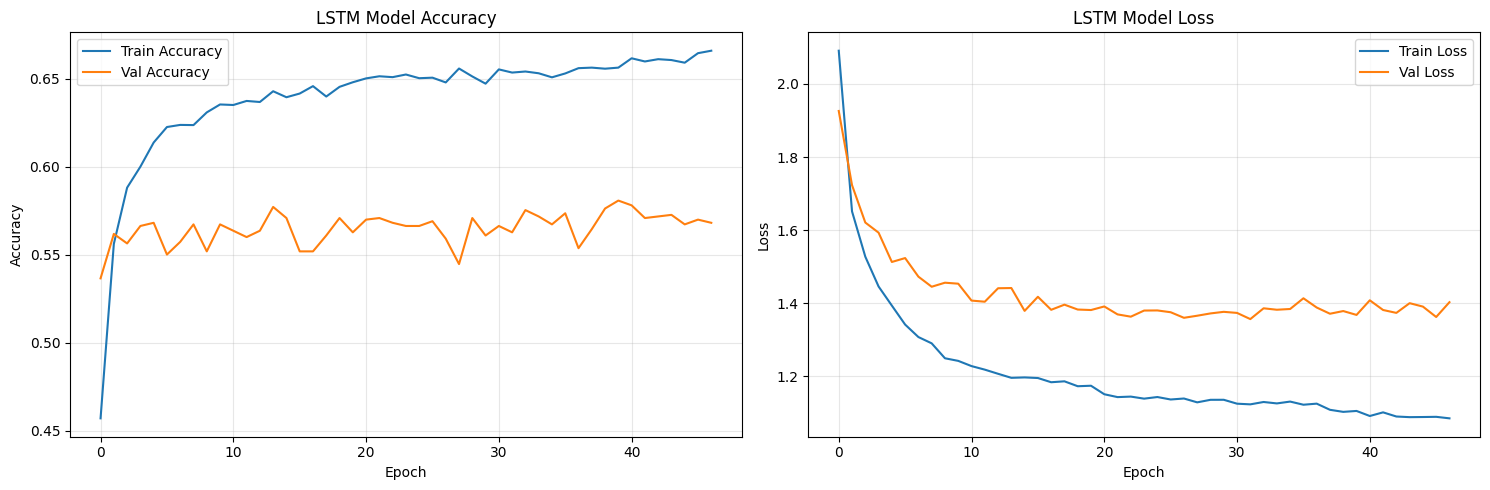

Final Training Accuracy: 0.6658
Final Validation Accuracy: 0.5681


In [29]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(lstm_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(lstm_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('LSTM Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(lstm_history.history['loss'], label='Train Loss')
axes[1].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[1].set_title('LSTM Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {lstm_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {lstm_history.history['val_accuracy'][-1]:.4f}")

### 3.4 Evaluate LSTM Model

In [ ]:
# Evaluate LSTM model on test set
print("LSTM Model Evaluation")
print("=" * 70)

# Get predictions
y_pred_probs = lstm_model.predict(X_text_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate test accuracy
test_loss, lstm_test_accuracy = lstm_model.evaluate(X_text_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LSTM Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 4.1 Load Spectrogram Data

In [ ]:
# Load pre-computed spectrograms
# Note: Spectrograms were generated using audio_to_spectrogram.ipynb
# They are already aligned with the labels (same indices)

spectrogram_path = 'MELD_spectrograms'

print(f"Loading spectrogram data from: {spectrogram_path}")
print("=" * 70)

X_audio_train = np.load(os.path.join(spectrogram_path, 'X_audio_train.npy'))
X_audio_val = np.load(os.path.join(spectrogram_path, 'X_audio_val.npy'))
X_audio_test = np.load(os.path.join(spectrogram_path, 'X_audio_test.npy'))

print(f"✓ Spectrogram data loaded successfully!")
print(f"  Train: {X_audio_train.shape}")
print(f"  Val: {X_audio_val.shape}")
print(f"  Test: {X_audio_test.shape}")

# Verify alignment with labels
assert X_audio_train.shape[0] == y_train.shape[0], "Train size mismatch!"
assert X_audio_val.shape[0] == y_val.shape[0], "Val size mismatch!"
assert X_audio_test.shape[0] == y_test.shape[0], "Test size mismatch!"

print(f"\n✓ Spectrograms are properly aligned with labels")
print("=" * 70)

### 4.2 Build CNN Model

In [ ]:
def build_2d_cnn_model(input_shape, num_classes):
    """
    Build 2D CNN for spectrogram-based emotion classification
    
    Args:
        input_shape: Shape of spectrogram input (height, width, channels)
        num_classes: Number of emotion classes
    
    Returns:
        Compiled Keras model
    """
    model = Sequential(name='CNN_Spectrogram_Model')
    
    # Conv Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Conv Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Conv Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Conv Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the CNN model
cnn_input_shape = X_audio_train.shape[1:]
cnn_model = build_2d_cnn_model(cnn_input_shape, num_classes)

print("CNN Model Architecture:")
cnn_model.summary()

### 4.3 Train CNN Model

In [ ]:
# Calculate class weights to handle imbalanced data
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights_array))

# Cap weights to prevent instability
for k, v in class_weights_dict.items():
    class_weights_dict[k] = min(v, 3.0)

print(f"Class weights: {class_weights_dict}")

# Compile CNN model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
cnn_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("\nTraining CNN model...")
print("=" * 70)

# Train the model
cnn_history = cnn_model.fit(
    X_audio_train, y_train_cat,
    validation_data=(X_audio_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=cnn_callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

print("\n✓ CNN model training complete!")
print(f"Best Validation Accuracy: {max(cnn_history.history['val_accuracy']):.4f}")

### 4.4 Visualize CNN Training

## 7. Train CNN Model Independently

In [ ]:
# =========================================================================
# CRITICAL: NO TRIMMING NEEDED - Arrays are already synchronized!
# =========================================================================
# The spectrograms in X_audio_train were generated using the EXACT same
# train_dia_ids and train_utt_ids that were used to create y_train.
# This means the i-th spectrogram corresponds to the i-th label by design.
#
# The previous trimming code was a symptom of the problem, not the solution.
# By generating spectrograms ONLY for the filtered ID lists from the label
# processing step, we ensure perfect 1:1 correspondence from the start.
# =========================================================================

# Verify alignment (should already be equal)
print(f"\nVerifying data alignment:")
print(f"  X_audio_train shape: {X_audio_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  X_audio_val shape: {X_audio_val.shape}")
print(f"  y_val shape: {y_val.shape}")
print(f"  X_audio_test shape: {X_audio_test.shape}")
print(f"  y_test shape: {y_test.shape}")

# Sanity check: Sizes should match exactly
assert X_audio_train.shape[0] == y_train.shape[0], \
    f"❌ Train size mismatch: {X_audio_train.shape[0]} spectrograms vs {y_train.shape[0]} labels"
assert X_audio_val.shape[0] == y_val.shape[0], \
    f"❌ Val size mismatch: {X_audio_val.shape[0]} spectrograms vs {y_val.shape[0]} labels"
assert X_audio_test.shape[0] == y_test.shape[0], \
    f"❌ Test size mismatch: {X_audio_test.shape[0]} spectrograms vs {y_test.shape[0]} labels"

print("\n✅ All arrays are properly aligned!")

# Compile CNN model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nTraining CNN model...")
print("=" * 50)

from tensorflow.keras.utils import to_categorical

# 1. Convert integer labels to One-Hot Encoding
# Ensure you use the correct number of classes (7 for MELD)
num_classes = 7
y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_val_ohe = to_categorical(y_val, num_classes=num_classes)


# Cap the weights to prevent instability
for k, v in class_weights_dict.items():
    class_weights_dict[k] = min(v, 3.0)

# Train the model with properly aligned data
cnn_history = cnn_model.fit(
    X_audio_train, y_train_ohe,  # Use original y_train, not y_train_audio
    validation_data=(X_audio_val, y_val_ohe),
    epochs=100,
    batch_size=32,
    callbacks=cnn_callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

print("\n✓ CNN model training complete!")



Verifying data alignment:
  X_audio_train shape: (9989, 128, 128, 1)
  y_train shape: (9989,)
  X_audio_val shape: (1109, 128, 128, 1)
  y_val shape: (1109,)
  X_audio_test shape: (2610, 128, 128, 1)
  y_test shape: (2610,)

✅ All arrays are properly aligned!

Training CNN model...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4774 - loss: 1.6874
Epoch 1: val_accuracy improved from -inf to 0.38954, saving model to best_cnn_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 484ms/step - accuracy: 0.4774 - loss: 1.6875 - val_accuracy: 0.3895 - val_loss: 1.9161 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4753 - loss: 1.6753
Epoch 2: val_accuracy did not improve from 0.38954
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.4752 - loss: 1.6753 - val_accuracy: 0.2768 - val_loss: 2.4937 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.4782 - loss: 1.6676
Epoch 3: val_accur

In [ ]:
# Plot CNN training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(cnn_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(cnn_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('CNN Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(cnn_history.history['loss'], label='Train Loss')
axes[1].plot(cnn_history.history['val_loss'], label='Val Loss')
axes[1].set_title('CNN Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {cnn_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {cnn_history.history['val_accuracy'][-1]:.4f}")

Class Weights being used: {0: np.float64(1.2867448151487826), 1: np.float64(5.265682656826568), 2: np.float64(5.324626865671642), 3: np.float64(0.8187033849684452), 4: np.float64(0.3029723991507431), 5: np.float64(2.089311859443631), 6: np.float64(1.1842323651452282)}


### 4.5 Evaluate CNN Model

In [ ]:
# Evaluate CNN model on test set
print("CNN Model Evaluation")
print("=" * 70)

# Get predictions
y_pred_probs = cnn_model.predict(X_audio_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate test accuracy
test_loss, cnn_test_accuracy = cnn_model.evaluate(X_audio_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CNN Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 5. Fusion Model (Multimodal Text + Audio Classification)

### 5.1 Build Fusion Model

In [ ]:
def build_fusion_model(text_input_shape, audio_input_shape, num_classes):
    """
    Build fusion model combining LSTM (text) and CNN (audio) branches
    
    Args:
        text_input_shape: Shape of text input (timesteps, features)
        audio_input_shape: Shape of audio input (height, width, channels)
        num_classes: Number of emotion classes
    
    Returns:
        Compiled Keras model
    """
    # Text branch (LSTM)
    text_input = Input(shape=text_input_shape, name='text_input')
    text_lstm = LSTM(128, return_sequences=True)(text_input)
    text_lstm = Dropout(0.3)(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_lstm = LSTM(64, return_sequences=False)(text_lstm)
    text_lstm = Dropout(0.3)(text_lstm)
    text_lstm = BatchNormalization()(text_lstm)
    text_dense = Dense(64, activation='relu')(text_lstm)
    text_dense = Dropout(0.3)(text_dense)
    
    # Audio branch (2D CNN)
    audio_input = Input(shape=audio_input_shape, name='audio_input')
    audio_conv = Conv2D(32, (3, 3), activation='relu', padding='same')(audio_input)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)
    
    audio_conv = Conv2D(64, (3, 3), activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)
    
    audio_conv = Conv2D(128, (3, 3), activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)
    
    audio_conv = Conv2D(256, (3, 3), activation='relu', padding='same')(audio_conv)
    audio_conv = BatchNormalization()(audio_conv)
    audio_conv = MaxPooling2D(pool_size=(2, 2))(audio_conv)
    audio_conv = Dropout(0.3)(audio_conv)
    
    audio_flat = Flatten()(audio_conv)
    audio_dense = Dense(128, activation='relu')(audio_flat)
    audio_dense = Dropout(0.4)(audio_dense)
    audio_dense = Dense(64, activation='relu')(audio_dense)
    audio_dense = Dropout(0.3)(audio_dense)
    
    # Fusion: Concatenate both branches
    fusion = Concatenate()([text_dense, audio_dense])
    fusion = Dense(128, activation='relu')(fusion)
    fusion = Dropout(0.4)(fusion)
    fusion = BatchNormalization()(fusion)
    fusion = Dense(64, activation='relu')(fusion)
    fusion = Dropout(0.3)(fusion)
    
    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(fusion)
    
    # Create model
    model = Model(inputs=[text_input, audio_input], outputs=output, name='Fusion_Model')
    return model

# Build the fusion model
fusion_model = build_fusion_model(
    (X_text_train.shape[1], X_text_train.shape[2]),
    X_audio_train.shape[1:],
    num_classes
)

print("Fusion Model Architecture:")
fusion_model.summary()

### 5.2 Train Fusion Model

In [ ]:
# Compile fusion model
fusion_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
fusion_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_fusion_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("Training Fusion model...")
print("=" * 70)

# Train the model with both text and audio inputs
fusion_history = fusion_model.fit(
    [X_text_train, X_audio_train], y_train_cat,
    validation_data=([X_text_val, X_audio_val], y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=fusion_callbacks,
    verbose=1
)

print("\n✓ Fusion model training complete!")
print(f"Best Validation Accuracy: {max(fusion_history.history['val_accuracy']):.4f}")

### 5.3 Visualize Fusion Training

In [ ]:
# Plot Fusion model training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(fusion_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(fusion_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Fusion Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(fusion_history.history['loss'], label='Train Loss')
axes[1].plot(fusion_history.history['val_loss'], label='Val Loss')
axes[1].set_title('Fusion Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {fusion_history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {fusion_history.history['val_accuracy'][-1]:.4f}")

### 5.4 Evaluate Fusion Model

In [ ]:
# Evaluate fusion model on test set
print("Fusion Model Evaluation")
print("=" * 70)

# Get predictions
fusion_pred_probs = fusion_model.predict([X_text_test, X_audio_test], verbose=0)
fusion_pred = np.argmax(fusion_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate test accuracy
fusion_test_loss, fusion_test_accuracy = fusion_model.evaluate(
    [X_text_test, X_audio_test], y_test_cat, verbose=0
)
print(f"Test Accuracy: {fusion_test_accuracy:.4f}")
print(f"Test Loss: {fusion_test_loss:.4f}")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_true, fusion_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, fusion_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Fusion Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 5.5 Compare All Models

In [ ]:
# Compare all three models
print("MODEL COMPARISON")
print("=" * 70)

models_comparison = pd.DataFrame({
    'Model': ['LSTM (Text Only)', 'CNN (Audio Only)', 'Fusion (Text + Audio)'],
    'Test Accuracy': [lstm_test_accuracy, cnn_test_accuracy, fusion_test_accuracy]
})

print(models_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(models_comparison['Model'], models_comparison['Test Accuracy'],
               color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=15, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Calculate improvement
improvement_over_lstm = ((fusion_test_accuracy - lstm_test_accuracy) / lstm_test_accuracy) * 100
improvement_over_cnn = ((fusion_test_accuracy - cnn_test_accuracy) / cnn_test_accuracy) * 100

print(f"\nFusion Model Improvements:")
print(f"  Over LSTM: {improvement_over_lstm:+.2f}%")
print(f"  Over CNN: {improvement_over_cnn:+.2f}%")

In [ ]:
# Per-class performance analysis
from sklearn.metrics import precision_recall_fscore_support

print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 70)

# Get predictions for all models
lstm_pred = np.argmax(lstm_model.predict(X_text_test, verbose=0), axis=1)
cnn_pred = np.argmax(cnn_model.predict(X_audio_test, verbose=0), axis=1)
fusion_pred = np.argmax(fusion_model.predict([X_text_test, X_audio_test], verbose=0), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Calculate F1 scores
lstm_precision, lstm_recall, lstm_f1, _ = precision_recall_fscore_support(
    y_true, lstm_pred, average=None, labels=range(num_classes)
)
cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(
    y_true, cnn_pred, average=None, labels=range(num_classes)
)
fusion_precision, fusion_recall, fusion_f1, _ = precision_recall_fscore_support(
    y_true, fusion_pred, average=None, labels=range(num_classes)
)

# Create comparison dataframe
per_class_df = pd.DataFrame({
    'Emotion': le.classes_,
    'LSTM F1': lstm_f1,
    'CNN F1': cnn_f1,
    'Fusion F1': fusion_f1,
    'Improvement': fusion_f1 - np.maximum(lstm_f1, cnn_f1)
})

print("\nF1-Score Comparison by Emotion Class:")
print(per_class_df.to_string(index=False))

# Visualize per-class F1 scores
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(le.classes_))
width = 0.25

bars1 = ax.bar(x - width, lstm_f1, width, label='LSTM', color='#3498db')
bars2 = ax.bar(x, cnn_f1, width, label='CNN', color='#e74c3c')
bars3 = ax.bar(x + width, fusion_f1, width, label='Fusion', color='#2ecc71')

ax.set_xlabel('Emotion Class')
ax.set_ylabel('F1-Score')
ax.set_title('Per-Class F1-Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nEmotions with highest fusion improvement:")
top_improvements = per_class_df.nlargest(3, 'Improvement')
for _, row in top_improvements.iterrows():
    print(f"  {row['Emotion']}: +{row['Improvement']:.4f}")